<a href="https://colab.research.google.com/github/egorssed/Fake_News_Detection/blob/main/Psychology_Data_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount= True)

Mounted at /content/drive


# Hypothesis

Given previous research on similar topics, we can pose several hypotheses.   

1. Personality traits vs Fake News:   
**Originality and Resiliency are positively related to the ability to detect Fake**. Originality and Emotional Stability appear to be positively and strongly associated with interest in and knowledge of politics (Chirumbolo et al. 2010). We suppose that interest and knowledge of politics improve fake news detection performance.  

2. Political leaning vs Fake News:   
**Fake news detection capabilities are not influenced by (moderate) Political leaning**. It has been found by Van Bavel and Pereira (Van_Bavel & Pereira 2018)

3. Personality traits vs Political leaning:   
**Conscientiousness, agreeableness, and originality are typically found to predict Political criteria**. It has been found by Chirumbolo et al. (Chirumbolo et al. 2010; Alan et al. 2016).


# Load Data

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import seaborn as sns
from os.path import join
import scipy
import statsmodels.regression.linear_model as LM
from matplotlib.ticker import MaxNLocator

plt.rcParams['figure.figsize'] = [7, 5]

In [ ]:
#Folder_path='drive/MyDrive/epfl/Fakenews/StatAnalysis/'
Folder_path='/content/drive/My Drive/Psychology/Fake News Detection/'

Data_path='Data_anonymized.csv'
df=pd.read_csv(join(Folder_path,Data_path),index_col=0)
df.head()

participant  ...  TIME_total
0  s.383a7ac8-51de-4be8-82f9-0a5adfab7f2f.txt  ...         NaN
1  s.a88c0a70-878f-4148-a335-ef8e351deee1.txt  ...         7.0
2  s.5eaa59ba-1dde-41c2-a4dd-9f7f8c0bd77a.txt  ...        13.0
3  s.59f16b8a-4207-4825-9342-43d56a9dc114.txt  ...        15.0
4  s.efdf6281-1c94-493f-8e5c-6a2e55dcd6bf.txt  ...        29.0

[5 rows x 92 columns]

# Data cleaning

Apparently there are no multi-gender people there, hence this column is completely useless

In [ ]:
print(np.isnan(df['gender:other']).all())
df.drop('gender:other',axis=1,inplace=True)

True


These people didn't manage to reach feeds, so there is no use in them either

In [ ]:
print('people who did not reach feeds',df[np.isnan(df['feed1_1:1'])].index.to_numpy())

people who did not reach feeds [ 0 71]


In [ ]:
df=df[np.logical_not(np.isnan(df['feed1_1:1']))]

Nan emails only. Seems sensible. I guess we can work with this dataset now.

In [ ]:
print('Columns with Nans',df.columns[df.isna().any()].to_numpy())

Columns with Nans []


# Results

## Data exploration

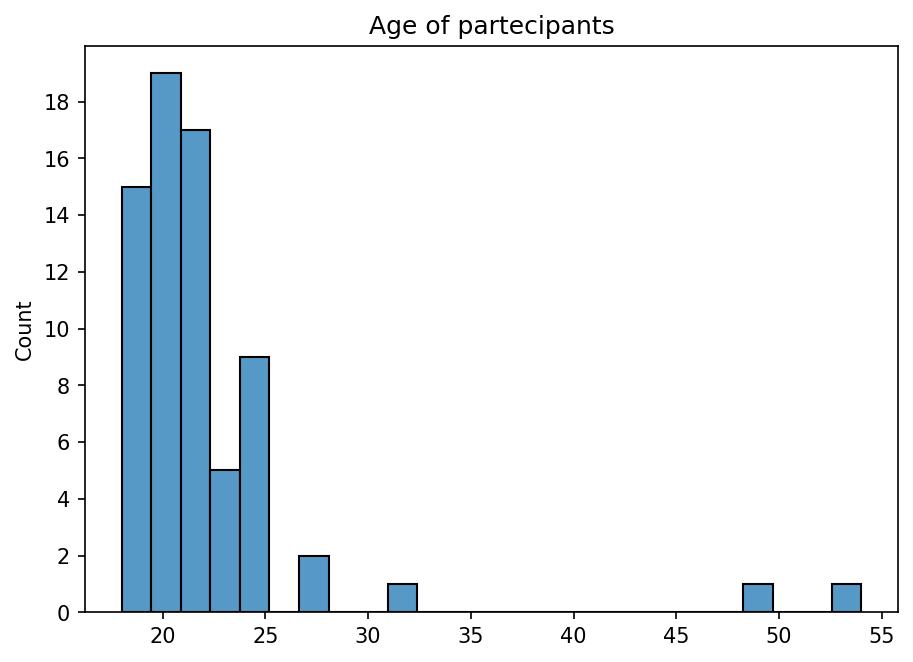

22.228571428571428
5.598906598795947
0.45714285714285713


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


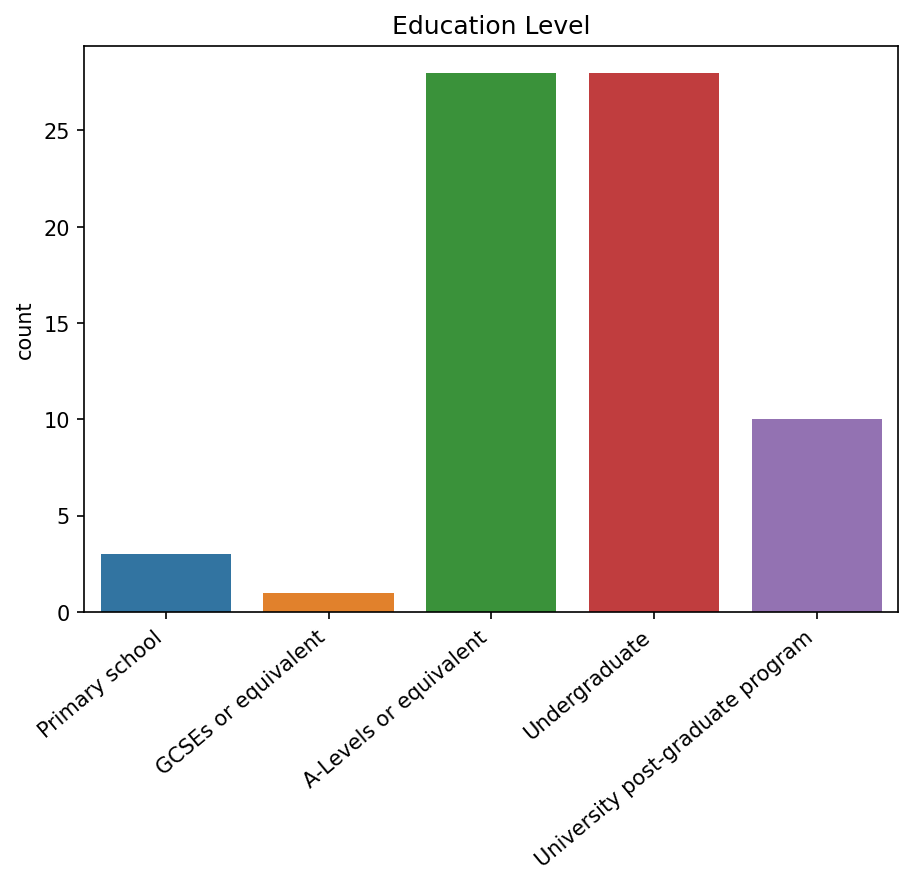

In [ ]:
ax = plt.figure(dpi = 150).gca()
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
sns.histplot(df['age:1'])
plt.title('Age of partecipants')
plt.xlabel('')
plt.show()


age = df['age:1']
print(np.mean(age))
print(np.std(age))

edu = df['education:1']
print(len(edu[edu<4]) / len(edu))

ax = plt.figure(dpi = 150).gca()
sns.countplot(df['education:1'])
plt.title('Education Level')
ax.set_xticklabels(('Primary school','GCSEs or equivalent','A-Levels or equivalent','Undergraduate', 'University post-graduate program'), rotation=40, ha="right")
plt.xlabel('')
plt.show()


In [ ]:
df['age:1'].describe()

count    70.000000
mean     22.228571
std       5.639332
min      18.000000
25%      20.000000
50%      21.000000
75%      23.000000
max      54.000000
Name: age:1, dtype: float64

In [ ]:
print("Percentage of women in the dataset {:.0f}%".format((df['gender:1']==2).sum()/len(df)*100))

Percentage of women in the dataset 67%


In [ ]:
Fake_news_raw=df[['Abortion FN','Climate TN','Domestic violence FN','Homophobia FN','Weed TN']]
Political_leaning=df[['Refugees', 'Healthcare', 'Basic quality of living', 'Same sex couples',
       'Abortion', 'National defense', 'Death penalty', 'Light drugs',
       'Climate change', 'Minorities', 'Self-identify']]

Personality_traits=df[['Agreeability','Consciousness','Extroversion','Honesty','Originality','Resiliency']]
Personality_traits.columns=['Agreeableness','Conscientiousness','Extraversion','Honesty','Originality','Resiliency']

In [ ]:
#Desctiption of normalised Hexaco dataset
Personality_traits_norm=(Personality_traits-Personality_traits.min(axis=0))
Personality_traits_norm/=Personality_traits_norm.max(axis=0)
Personality_traits_norm.describe()

Agreeableness  Conscientiousness  ...  Originality  Resiliency
count      70.000000          70.000000  ...    70.000000   70.000000
mean        0.531746           0.510317  ...     0.562857    0.447619
std         0.253544           0.213033  ...     0.192496    0.245169
min         0.000000           0.000000  ...     0.000000    0.000000
25%         0.333333           0.333333  ...     0.466667    0.222222
50%         0.527778           0.500000  ...     0.566667    0.444444
75%         0.722222           0.666667  ...     0.666667    0.611111
max         1.000000           1.000000  ...     1.000000    1.000000

[8 rows x 6 columns]

### Fake news

In [ ]:
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
fig = plt.figure(figsize= (20,10))
for i,name in enumerate(Fake_news_raw.columns):
  plt.subplot(2,3,i+1)
  
  ax = sns.countplot(Fake_news_raw.iloc[:,i],color = colors[i])
  ax.set_xticklabels( labels = np.arange(0,11))
  plt.title(name)
  plt.xlabel('')

plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn

During the questionnaire, participants were asked to estimate their trust to present pieces of news on a scale from 0 to 10 with step 1. In other terms, they were asked to classify the piece as either True or False, by answering with probability of the piece being True. Such a task can be naturally named as a task of binary classification, hence the cost of deviation from correct answer can be measured as informational entropy between distribution of correct answers and distribution of predicted probabilities. Such logic brings us to conclusion that Fake News score detection should be measured as Binary Crossentropy.

In [ ]:
#0*np.log(0)=0, whereas numpy thinks that it is nan 
def entropy_loss(Answers,Probabilities):
    Loss=np.log(Probabilities)
    Loss[Loss==-np.inf]=0
    return Answers*Probabilities

In [ ]:
def get_BCE(Answers,Dataset):
  #Numpy thinks that nan*0=nan so we turn nan to 0 explicitly
  False_loss=entropy_loss(Answers,Dataset)
  True_loss=entropy_loss(1-Answers,1-Dataset)

  print('Any infs?',np.isinf(False_loss).any().any(),np.isinf(True_loss).any().any())

  # That's negative BCE, so 1-guessed everything, 0-guessed nothing
  BCE=(False_loss+True_loss)/Fake_news.shape[1]
  plt.show()
  return BCE

In [ ]:
Fake_news=Fake_news_raw/10
Fake_news_answers=np.array([False,True,False,False,True])



BCE_original=get_BCE(Fake_news_answers,Fake_news)
plt.figure(dpi = 150)
BCE_original.sum(axis=1).plot.hist(title='Total Fake News Score',xlim=(0.3,0.9))
plt.show()
BCE_scores=BCE_original*5
BCE_scores['Total']=BCE_scores.mean(axis=1)
print(BCE_original.sum(axis=1).std())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


Any infs? False False


0.09124898252361066


In [ ]:
BCE_scores.describe()

Abortion FN  Climate TN  ...    Weed TN      Total
count    70.000000   70.000000  ...  70.000000  70.000000
mean      0.847143    0.485714  ...   0.414286   0.578000
std       0.230765    0.236696  ...   0.308472   0.091249
min       0.100000    0.000000  ...   0.000000   0.400000
25%       0.725000    0.300000  ...   0.125000   0.505000
50%       1.000000    0.500000  ...   0.400000   0.580000
75%       1.000000    0.600000  ...   0.675000   0.635000
max       1.000000    1.000000  ...   1.000000   0.840000

[8 rows x 6 columns]

In [ ]:
def bootstrap_CI_func(data,func, nbr_draws=1000):
    res = np.zeros(nbr_draws)
    data = np.array(data)

    for n in range(nbr_draws):
        indices = np.random.randint(0, len(data), len(data))
        data_tmp = data[indices] 
        res[n] = func(data_tmp)

    return [np.nanpercentile(res, 2.5),np.nanpercentile(res, 97.5)]

95 % significance

In [ ]:
low_CI,high_CI=bootstrap_CI_func(BCE_original.sum(axis=1),np.mean)
print("95% Confidence intervals for mean value of Fake News detection score [{:.2f},{:.2f}]".format(low_CI,high_CI))

95% Confidence intervals for mean value of Fake News detection score [0.56,0.60]


### Political Leaning

Normalise it in the first place. And make it zero-centered

In [ ]:
Political_leaning=(Political_leaning-5.5)/4.5
Political_leaning.head()

Refugees  Healthcare  ...  Minorities  Self-identify
1 -0.777778        -1.0  ...   -0.555556      -1.000000
2 -0.555556        -1.0  ...    0.111111      -0.777778
3 -0.777778        -1.0  ...    0.333333      -0.555556
4 -1.000000        -1.0  ...   -1.000000      -0.777778
5 -1.000000        -1.0  ...   -1.000000      -1.000000

[5 rows x 11 columns]

In [ ]:
ProAuthoritarian_columns=['Refugees', 'Healthcare', 'Basic quality of living', 'Same sex couples','National defense','Climate change', 'Minorities']
ProLibertarian_columns=['Abortion','Death penalty', 'Light drugs']
Political_leaning['Political_score']=(Political_leaning[ProAuthoritarian_columns].sum(axis=1)
                                      -Political_leaning[ProLibertarian_columns].sum(axis=1))/(Political_leaning.shape[1]-1)

<Figure size 1050x750 with 0 Axes>

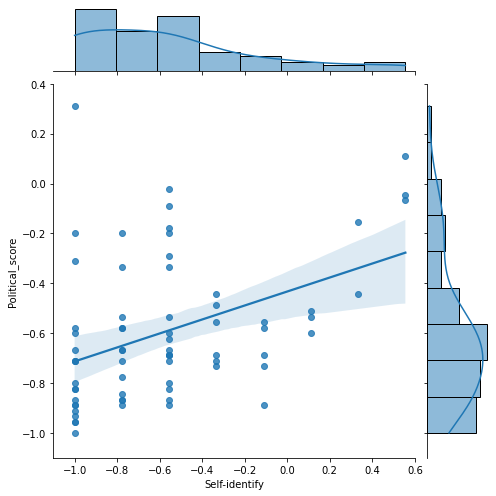

SpearmanrResult(correlation=0.4314237311600313, pvalue=0.0001924101387843294)

In [ ]:
plt.figure(dpi = 150)
g=sns.jointplot(x='Self-identify', y='Political_score', data=Political_leaning,
                  kind="reg",height=7,xlim=(-1.1,0.6),ylim=(-1.1,0.4))
plt.show()
scipy.stats.spearmanr(Political_leaning[['Political_score','Self-identify']])

Normalized Polititcal leaning

In [ ]:
PL_norm=(Political_leaning+1)
PL_norm/=2

plt.figure(dpi = 150)
g=sns.jointplot(x='Self-identify', y='Political_score', data=PL_norm,
                  kind="reg",height=7,xlim=(-0.05,0.8),ylim=(-0.05,0.7))
plt.show()

<Figure size 1050x750 with 0 Axes>

Correlation seems to be significant (pvalue<0.05), yet function description reads "The p-values are not entirely reliable but are probably reasonable for datasets larger than 500 or so." Therefore we can not really state anything for 70 instances dataset. I pearsonally see that we have some correlation only starting from -0.25 Self-identify. These are centrist or authoritarian people 

### Personality traits

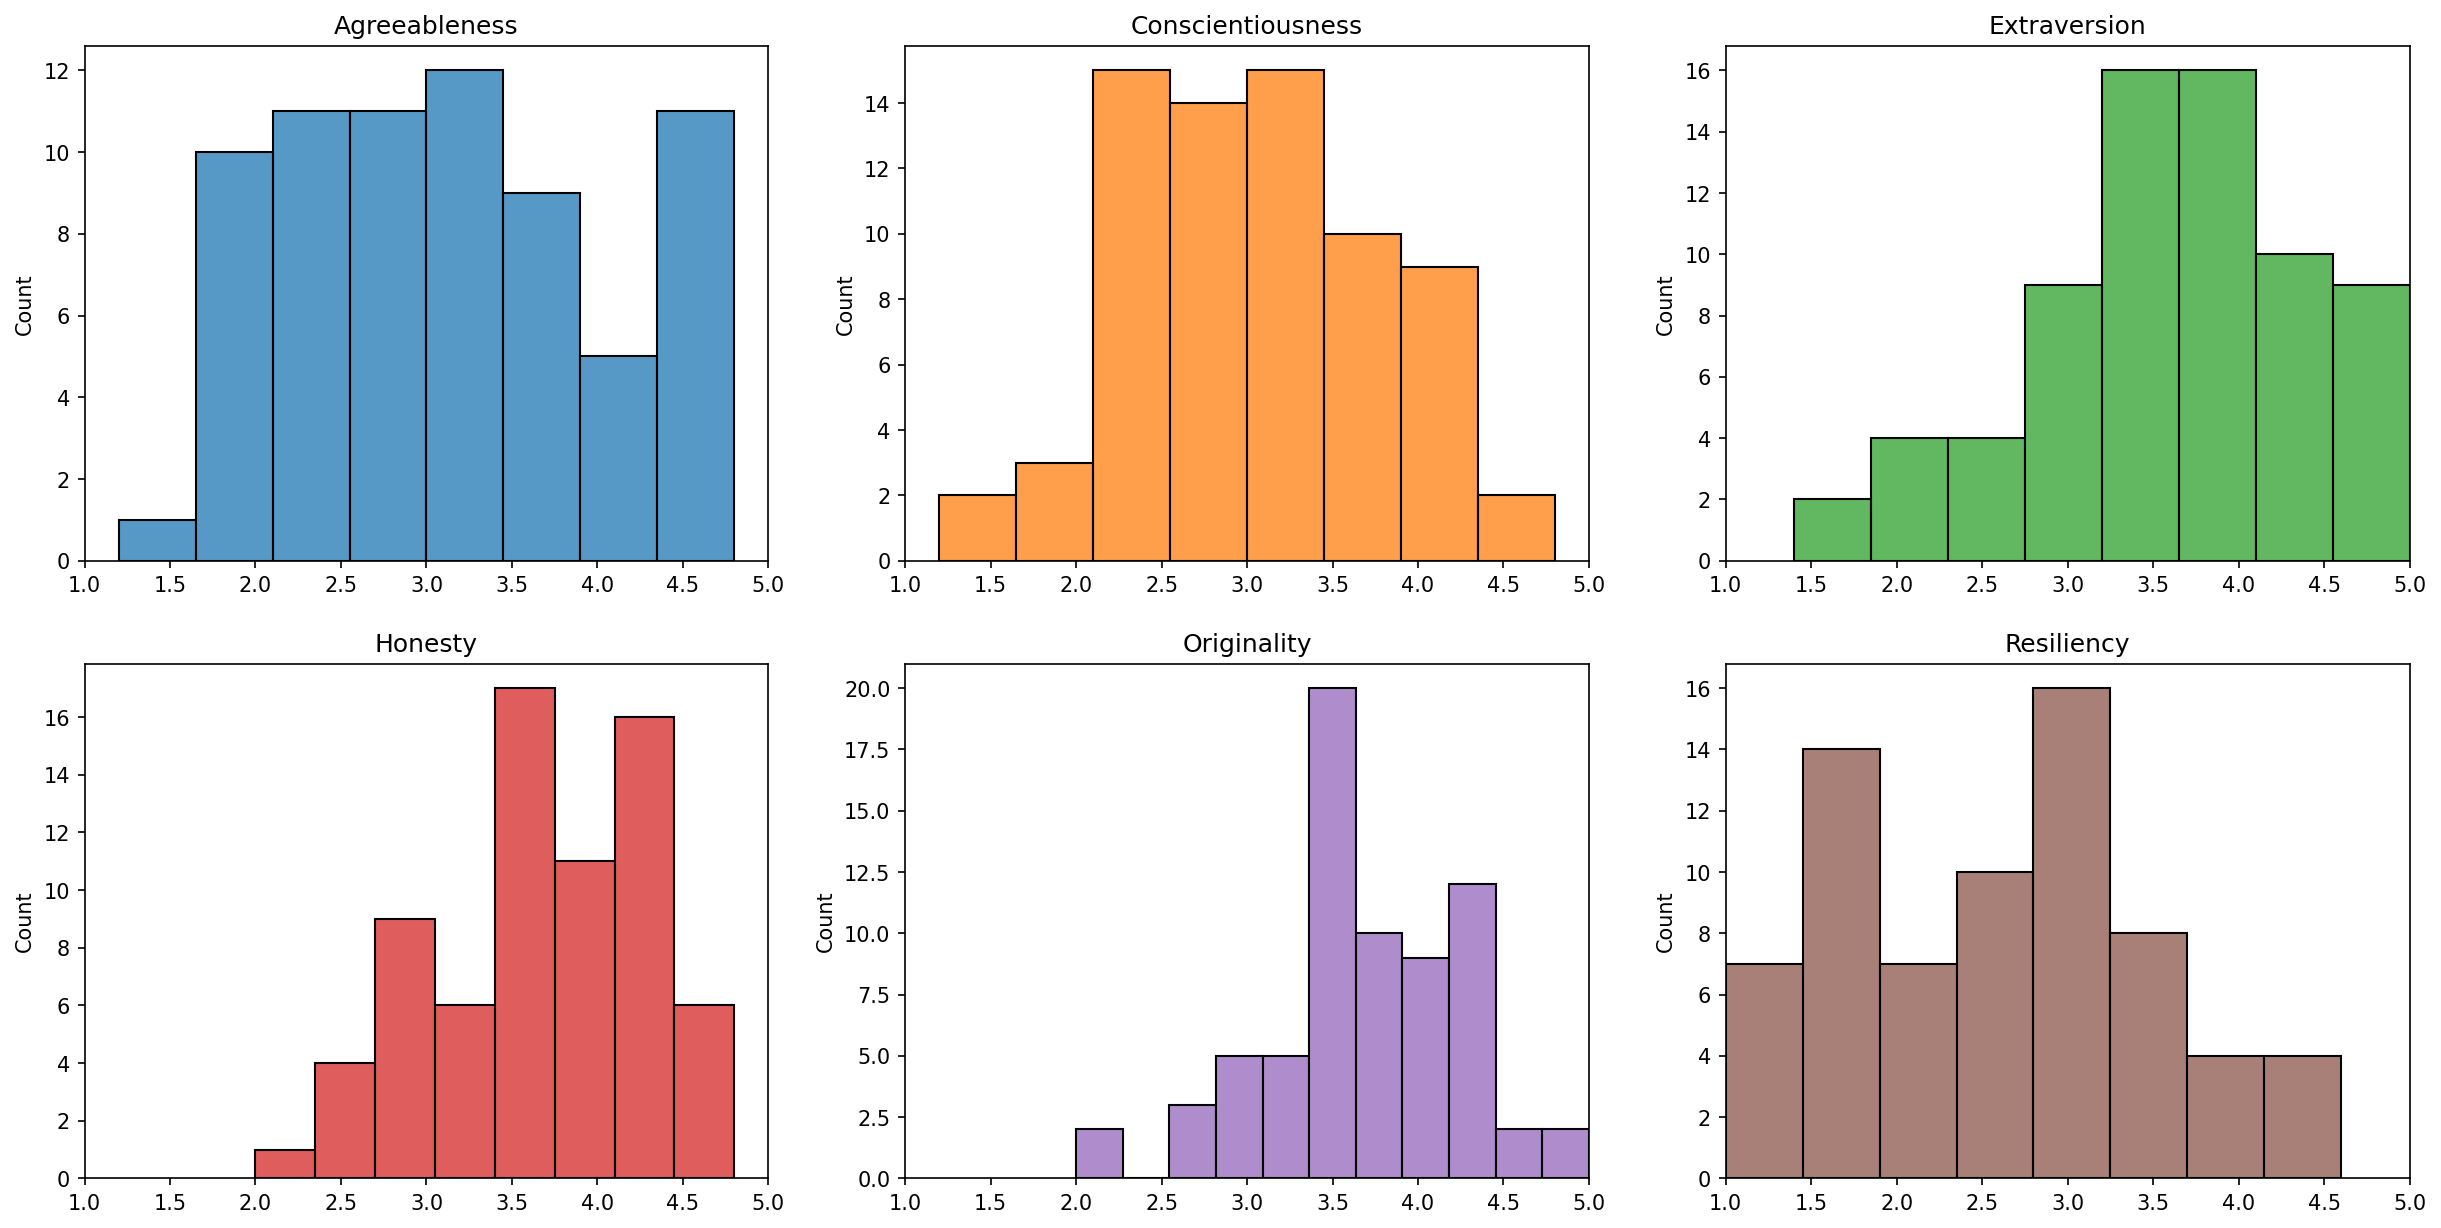

In [ ]:
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
fig = plt.figure(figsize= (20,10),dpi=150)
for i,name in enumerate(Hexaco.columns):
  plt.subplot(2,3,i+1)
  
  ax = sns.histplot(Hexaco.iloc[:,i],color = colors[i])
  plt.xlim((1,5))
  
  plt.title(name)
  plt.xlabel('')

plt.show()

## Spearman rank correlations

In [ ]:
df_all=BCE_scores.drop('Total',axis=1).copy()
df_all['Fake_news_score']=df_all.mean(axis=1)
df_all=df_all.merge(Political_leaning,left_index=True,right_index=True)
df_all=df_all.merge(Personality_traits,left_index=True,right_index=True)
df_all.head()

Abortion FN  Climate TN  ...  Originality  Resiliency
1          0.6         0.3  ...          4.0         1.6
2          1.0         0.2  ...          3.6         1.6
3          1.0         0.4  ...          3.2         1.8
4          1.0         0.7  ...          4.2         3.6
5          0.7         0.8  ...          5.0         2.6

[5 rows x 24 columns]

In [ ]:
def spearmanr_pval(x,y):
    return scipy.stats.spearmanr(x,y)[1]

# calculate the correlations
corr = df_all.corr(method='spearman')
# calculate p-values
corr_p = df_all.corr(method=spearmanr_pval)

In [ ]:
# select correlations and p-values of interest, namely Fake News columns
# Also get rid of Fake News indices (iloc[6:]), since they obviously have corr=1
corr_selected = corr[df_all.columns[:6]].loc[df_all.columns.values].iloc[6:]
corr_p_selected = corr_p[df_all.columns[:6]].loc[df_all.columns.values].iloc[6:]
#print(corr[corr_p < 0.051]['Resiliency'])
#print(corr_p['Resiliency'])

In [ ]:
#Split correlations on Fake News, Political Leaning and Personality traits
corr_FN_PolitLeaning = corr[df_all.columns[:6]].loc[df_all.columns.values].iloc[6:-6]
corr_p_FN_PolitLeaning = corr_p[df_all.columns[:6]].loc[df_all.columns.values].iloc[6:-6]

corr_FN_Personality = corr[df_all.columns[:6]].loc[df_all.columns.values].iloc[-6:]
corr_p_FN_Personality = corr_p[df_all.columns[:6]].loc[df_all.columns.values].iloc[-6:]

corr_PolitLeaning_Personality = corr[df_all.columns[-6:]].iloc[6:-6]
corr_p_PolitLeaning_Personality = corr_p[df_all.columns[-6:]].iloc[6:-6]

### Political leaning vs Fake News

In [ ]:
mask_Siginficant_rows_cols=np.where((corr_p_FN_PolitLeaning<0.05).any(axis=1))[0],np.where((corr_p_FN_PolitLeaning<0.05).any(axis=0))[0]

corr_p_FN_PolitLeaning=corr_p_FN_PolitLeaning.iloc[mask_Siginficant_rows_cols]
corr_FN_PolitLeaning=corr_FN_PolitLeaning.iloc[mask_Siginficant_rows_cols]
corr_FN_PolitLeaning[corr_p_FN_PolitLeaning>0.05]=np.nan

In [ ]:
FN_columns=np.array(corr_FN_PolitLeaning.columns)
FN_columns[:-1]=[x[:-2] for x in corr_FN_PolitLeaning.columns[:-1]]

plt.figure(figsize=(11,9))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(250, 15, s=75, l=40,n=9,as_cmap=True,center='dark')
# Draw the heatmap with the mask and correct aspect ratio
b = sns.heatmap(corr_FN_PolitLeaning, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
b.set_title('Significant Spearman correlation')
b.set_xlabel('Fake News')
b.set_ylabel('Political leaning questions')
b.set_yticklabels(b.get_yticklabels(), size = 9)
b.set_xticklabels(FN_columns, size = 9)

plt.show()

We do not see a significant correlation between overall Political leaning and overall Fake News score. However, we find a lot of correlations between specific topics of Political leaning and specific Fake News.  Moreover, we find significant correlation for two Political leaning features with overall Fake News score and for two specific Fake News scores with overall Political leaning.
Yet specific features concerned in these correlations appear to have mostly disbalanced distribution, since most of participants voted for one border value. 
To test whether significance is caused by disbalance we excluded people answered border values and estimated correlations again.

In [ ]:
df_unbiased=df_all[df_all['Abortion FN']!=df_all['Abortion FN'].min()]
scipy.stats.spearmanr(df_unbiased['Abortion FN'],df_unbiased['Political_score'])

SpearmanrResult(correlation=-0.29791375138891946, pvalue=0.012912189262002645)

In [ ]:
df_unbiased=df_all[df_all['Homophobia FN']!=df_all['Homophobia FN'].min()]
scipy.stats.spearmanr(df_unbiased['Homophobia FN'],df_unbiased['Political_score'])

SpearmanrResult(correlation=-0.35063221325405525, pvalue=0.0033737070877100117)

In [ ]:
#It was marginally insignificant, let's take a look at the change anyway
print("Disbalanced p value",corr_p_FN_PolitLeaning.loc['Healthcare','Fake_news_score'])
df_unbiased=df_all[df_all['Healthcare']!=df_all['Healthcare'].min()]
print("Balanced",scipy.stats.spearmanr(df_unbiased['Healthcare'],df_unbiased['Fake_news_score']))

Disbalanced p value 0.050835851261154585
Balanced SpearmanrResult(correlation=-0.27628890687125324, pvalue=0.1324378246617971)


In [ ]:
df_unbiased=df_all[df_all['Same sex couples']!=df_all['Same sex couples'].min()]
scipy.stats.spearmanr(df_unbiased['Same sex couples'],df_unbiased['Fake_news_score'])

SpearmanrResult(correlation=-0.3361143175561732, pvalue=0.12616900770295142)

For balanced dataset both overall Fake news score-related correlations became insignificant, therefore we can conclude that they are due to disbalance, rather than natural impact of specific political leaning aspects.

### Personality traits vs Fake News

In [ ]:
corr_FN_Personality[corr_p_FN_Personality>0.05]=np.nan

In [ ]:
FN_columns=np.array(corr_FN_Personality.columns)
FN_columns[:-1]=[x[:-2] for x in corr_FN_Personality.columns[:-1]]

plt.figure(figsize=(11,9))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(250, 15, s=75, l=40,n=9,as_cmap=True,center='dark')
# Draw the heatmap with the mask and correct aspect ratio
b = sns.heatmap(corr_FN_Personality, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
b.set_title('Significant Spearman correlation')
b.set_xlabel('Fake News')
b.set_ylabel('Personality traits')
b.set_yticklabels(b.get_yticklabels(), size = 9)
b.set_xticklabels(FN_columns, size = 9)

plt.show()

There is only one Personality trait significantly (p=.03) correlating with only one specific Fake News piece detection

### Personality traits vs Political leaning

In [ ]:
mask_Siginficant_rows_cols=np.where((corr_p_PolitLeaning_Personality<0.05).any(axis=1))[0],np.where((corr_p_PolitLeaning_Personality<0.05).any(axis=0))[0]

corr_p_PolitLeaning_Personality=corr_p_PolitLeaning_Personality.iloc[mask_Siginficant_rows_cols]
corr_PolitLeaning_Personality=corr_PolitLeaning_Personality.iloc[mask_Siginficant_rows_cols]
corr_PolitLeaning_Personality[corr_p_PolitLeaning_Personality>0.05]=np.nan

In [ ]:
FN_columns=np.array(corr_PolitLeaning_Personality.columns)
FN_columns[:-1]=[x[:-2] for x in corr_PolitLeaning_Personality.columns[:-1]]

plt.figure(figsize=(11,9))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(250, 15, s=75, l=40,n=9,as_cmap=True,center='dark')
# Draw the heatmap with the mask and correct aspect ratio
b = sns.heatmap(corr_PolitLeaning_Personality, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
b.set_title('Significant Spearman correlation')
b.set_xlabel('Personality traits')
b.set_ylabel('Political leaning questions')
b.set_yticklabels(b.get_yticklabels(), size = 9)
#b.set_xticklabels(FN_columns, size = 9)

plt.show()

In this section, we got several significant and logically sensible correlations
For instance, extroverts empathize more to mothers who don’t want to have a child, hence extroverts approve abortion.

## Linear regressions

In [ ]:
from statsmodels.regression.linear_model import OLS

def get_regression_summary(X,y):
    #envoke a model that predicts label by all the demographic features
    model = LM.OLS(y, X)
    res = model.fit()
    #Transform results with LR coefficients to DataFrame
    results_as_html = res.summary().tables[1].as_html()
    df_summary=pd.read_html(results_as_html, header=0, index_col=0)[0]
    
    #Consider only significant coefficients
    print("F-statistic p_value {:.3f}".format(res.f_pvalue))
    return df_summary[df_summary['P>|t|']<0.05][['coef', 'std err', 'P>|t|','[0.025','0.975]']],res

In this method we normalize all features to have M=0,SD=1, so that they all have the same initial impact. Next we try to predict target parameter using linear regression over considered features. In this case linear coefficients mark an impact of a given feature on target excluding confounding impact of the other features.

In [ ]:
Features=df_all.copy()
Features-=Features.mean(axis=0)
Features/=Features.std(axis=0)

### Political score vs Fake News score

F-statistic p_value 0.035


coef  std err  P>|t|  [0.025  0.975]
Political_score -0.2503    0.117  0.035  -0.483  -0.018

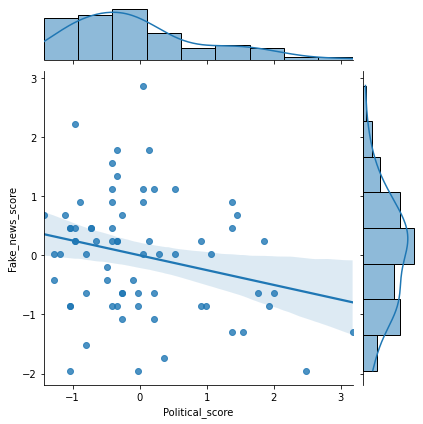

In [ ]:
X=Features['Political_score']
y=Features['Fake_news_score']
df_coefs,model=get_regression_summary(X,y)
sns.jointplot(x=X,y=y,kind="reg")
df_coefs

### Personality traits vs Fake News score

In [ ]:
X=Features.loc[:,Personality_traits.columns]
y=Features['Fake_news_score']
df_coefs,model=get_regression_summary(X,y)
df_coefs

F-statistic p_value 0.388


Empty DataFrame
Columns: [coef, std err, P>|t|, [0.025, 0.975]]
Index: []

No Personality features features have a significant impact on the Fake News score

### Personality traits vs Political leaning score

In [ ]:
X=Features.loc[:,Personality_traits.columns]
y=Features['Political_score']
df_coefs,model=get_regression_summary(X,y)
sns.jointplot(x=X[df_coefs.index[0]],y=y,kind="reg")
df_coefs

F-statistic p_value 0.105


coef  std err  P>|t|  [0.025  0.975]
Extraversion -0.3075    0.119  0.012  -0.545   -0.07

# Discussion

## Personality traits vs Fake News

In this section the hypothesis was **“Originality and Resiliency are positively related to the ability to detect fake news”**.  

However, in practice, no strong correlation for either Originality (P=.31 for Spearman correlation and P=.5 for Linear regression) or Resiliency (P=.66 for Spearman correlation and P=.9 for Linear regression) were found. None of Big 6 features showed significance in either correlation or linear impact. Therefore, we can conclude that on the given data we find our first hypothesis disproved.Moreover, we can suggest that Personality traits may not affect Fake News detection at all.   

Our hypothesis was drawn from a diverse political spectrum research whereas our sample of participants has political views from liberal to centrists (M=0.2, SD=0.14 with 0 for Liberal and 1 for Conservative), moreover, average age was 22.23 years (SD=5.64). The fact that our sample was disbalanced in these features implies that our results may be applied only on these people subclasses, yet they can not be certainly extrapolated on any given sample of people.

In [ ]:
FN_columns=np.array(corr_FN_Personality.columns)
FN_columns[:-1]=[x[:-2] for x in corr_FN_Personality.columns[:-1]]

plt.figure(figsize=(11,9))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(250, 15, s=75, l=40,n=9,as_cmap=True,center='dark')
# Draw the heatmap with the mask and correct aspect ratio
b = sns.heatmap(corr_FN_Personality, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
b.set_title('Significant Spearman correlation')
b.set_xlabel('Fake News')
b.set_ylabel('Personality traits')
b.set_yticklabels(b.get_yticklabels(), size = 9)
b.set_xticklabels(FN_columns, size = 9)

plt.show()

In [ ]:
X=Features.loc[:,Personality_traits.columns]
y=Features['Fake_news_score']
df_coefs,model=get_regression_summary(X,y)
df_coefs

F-statistic p_value 0.388


Empty DataFrame
Columns: [coef, std err, P>|t|, [0.025, 0.975]]
Index: []

## Political leaning vs Fake News

In this section out hypothesis was **“Fake news detection capabilities are not influenced by (moderate) political leaning”**.
 However, using method based on linear regression we significantly (P=.04) find that Liberals are better in resolving Fake News then Centrists  (M=-0.25, SD=0.12, in the table and figure).

F-statistic p_value 0.035


coef  std err  P>|t|  [0.025  0.975]
Political_score -0.2503    0.117  0.035  -0.483  -0.018

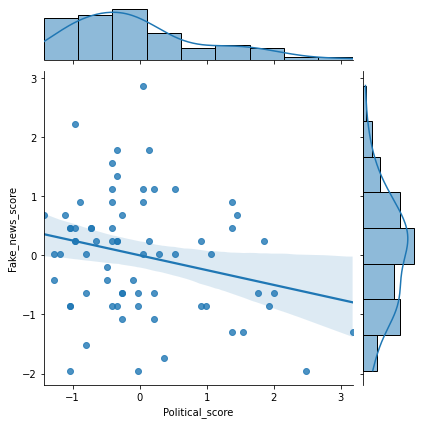

In [ ]:
X=Features['Political_score']
y=Features['Fake_news_score']
df_coefs,model=get_regression_summary(X,y)
sns.jointplot(x=X,y=y,kind="reg")
df_coefs

Sindermann et al. 2020 showed that Right-Wing Authoritarianism is associated with selective interest in information fitting with one’s attitudes.  

From our results, we may conclude that this effect may propagate on centrists resulting in worse performance in Fake News detection. On the other hand, in same article, there was small evidence on the fact that liberals tend to consume a higher number of news sources. It may improve their ability to resolve Fake News due to considering information coming from different sources. Both of these explanations may work as they coincide with the findings of our study.

## Personality traits vs Political leaning

In this section the hypothesis drawn from Chirumbolo et al 2010  was **“Conscientiousness, agreeableness, and originality are typically found to predict political criteria”**. Unlikely, analysis of Spearman correlations confirmed only agreeableness to predict political criteria (R=-0.28, P=.02).

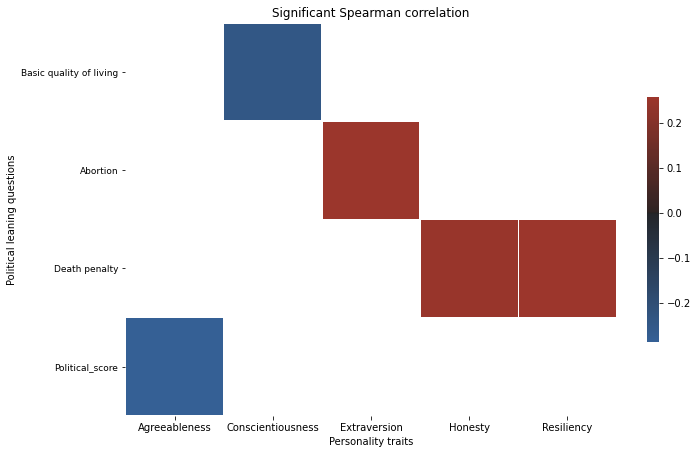

In [ ]:
FN_columns=np.array(corr_PolitLeaning_Personality.columns)
FN_columns[:-1]=[x[:-2] for x in corr_PolitLeaning_Personality.columns[:-1]]

plt.figure(figsize=(11,9))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(250, 15, s=75, l=40,n=9,as_cmap=True,center='dark')
# Draw the heatmap with the mask and correct aspect ratio
b = sns.heatmap(corr_PolitLeaning_Personality, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
b.set_title('Significant Spearman correlation')
b.set_xlabel('Personality traits')
b.set_ylabel('Political leaning questions')
b.set_yticklabels(b.get_yticklabels(), size = 9)
#b.set_xticklabels(FN_columns, size = 9)

plt.show()

The other method rejects this hypothesis altogether. The analysis of linear regression has shown only Extraversion to be a predictive factor for Political leaning (M=-0.3, SD=0.12, P=.02 for linear coefficient)

F-statistic p_value 0.105


coef  std err  P>|t|  [0.025  0.975]
Extraversion -0.3075    0.119  0.012  -0.545   -0.07

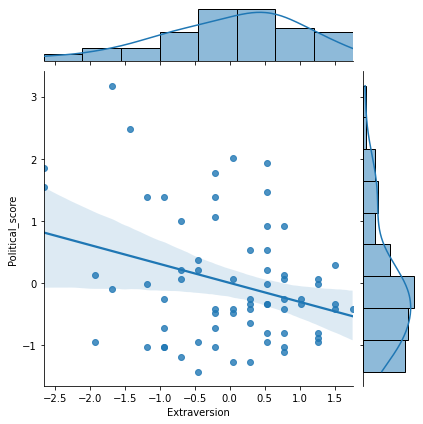

In [ ]:
X=Features.loc[:,Personality_traits.columns]
y=Features['Political_score']
df_coefs,model=get_regression_summary(X,y)
sns.jointplot(x=X[df_coefs.index[0]],y=y,kind="reg")
df_coefs

In the article Gerber et al. 2011 it was shown that extraverts are likely to report that they are interested in politics, watching political talk shows and network news.   

In a turn, Sindermann et al. 2020 showed a small evidence on the fact that liberals tend to consume a higher number of news sources.   

From this, we conclude that for Extraversion and Political leaning number of news usually consumed is a correlating trait and may work as a confounding factor for relation between these features.   

In following work, given more data the information may be propagated through correlating features in order to reduce the confounding variables for considered features.

# Conclusion

In this work, we have studied a sample of mostly undergraduate young people with Liberal to Centrist political views. We found that for this subgroup Personality traits do not impact Fake News detection performance, in contrast to Political Leaning, for which Liberals resolve fakes better than Centrists. The relations between Political leaning and Personality traits were found only for Agreeableness and Extraversion. The presence of relation for Agreeableness was already shown in previous articles, whereas for Extraversion we suggest this relation might be present due to a confounding factor, namely that Extraverts and Liberals consume news from more sources than the others. 

The findings of this research may help social networks to understand how susceptible to fake news their audience is. Given this data, social networks will gain possibility to distribute resources of news validation more efficiently. Moreover, during election campaigns, it is always important to understand the electorate’s susceptibility to unconfirmed statements to build a sensitive strategy of opposing accusations of the other political side and creating their announcements. 

We also find that the correlation is present between performance of detection specific topics and specific Political related questions or specific Personality traits. The findings seem sensible, however, they need to be tested on a higher number of Fake News questions and a more vast sample of participants. Furthermore, variety of age, education level, and political leaning should also be extended to validate possibility to extrapolate results found in this study on a more general sample of participants.